## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A project to discuss the results of an A/B test run by an e-commerce website. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [2]:
# Read in the dataset and take a look at the top few rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# The number of rows in the dataset.
df.shape[0]

294478

In [4]:
# The number of unique users in the dataset.
df['user_id'].nunique()

290584

In [10]:
# The proportion of unique users converted.
df[df['user_id'].duplicated() == False]['converted'].mean()

0.11956955647936569

### The number of times the `new_page` and `treatment` don't match :

In [11]:
# treatment but not new_page 
treat_df = df[df['group'] == 'treatment']
treat_no_new = treat_df[treat_df['landing_page'] != 'new_page']
# new_page but not treatment
new_df = df[df['landing_page'] == 'new_page']
new_no_treat = new_df[new_df['group'] != 'treatment']
# adding the number of no allignment of both 
treat_no_new.shape[0] + new_no_treat.shape[0]

3893

In [12]:
# Checking missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

###### There is not any missing values 

## Remove rows where 'treatment' does not match with 'new_page' or 'control' does not match with 'old_page'

In [13]:
# control but not old_page 
control_df = df[df['group'] == 'control']
control_no_old = control_df[control_df['landing_page'] != 'old_page']
# old_page but not control
old_df = df[df['landing_page'] == 'old_page']
old_no_control = old_df[old_df['group'] != 'control']

In [14]:
# conactenate indices of all messy rows 
messy_indices = treat_no_new.index.tolist() + new_no_treat.index.tolist() + control_no_old.index.tolist() + old_no_control.index.tolist()
# drop all messy rows 
df2 = df.drop(messy_indices, axis=0)

In [15]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [16]:
# Number of unique user_ids in df2
df2['user_id'].nunique()

290584

In [17]:
# The user_id that is repeated in df2
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

In [18]:
# The row information for the repeat user_id
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [19]:
# Remove one of the rows with a duplicate user_id
df2 = df2.drop(df2[df2['user_id'].duplicated()].index, axis=0)

In [20]:
# check for the removal of the duplicated 
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted


In [21]:
# The probability of an individual converting regardless of the page they receive
df2['converted'].mean()

0.11959708724499628

In [22]:
# The probability of an individual converted given that he was in the control group  
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

In [23]:
# The probability of an individual converted given that he was in the treatment group 
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

In [24]:
# The probability that an individual received the new page
df2[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]

0.5000619442226688

###### There is no sufficient evidence that the new treatment page leads to more conversions, both probabilities of control and experiment individuals who converted seem to be approximately equal and also approximately equal to those who converted regardless the page, a more reliable test like A/B test that depends on hypothesis test should be used  

<a id='ab_test'></a>
### Part II - A/B Test

###### Null hypothesis : P𝑜𝑙𝑑 >= P𝑛𝑒𝑤
###### Alternative hypothesis : Pold < Pnew

-Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>
-Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

In [25]:
# The conversion rate for Pnew under the null assuming that Pnew = Pold = p
p = df2['converted'].mean()
p 

0.11959708724499628

In [26]:
# The conversion rate for 𝑝𝑜𝑙𝑑  under the null assuming that Pnew = Pold = p
p

0.11959708724499628

In [27]:
# The number of individuals in the treatment group
df2[df2['group'] == 'treatment'].shape[0]

145310

In [28]:
# The number of individuals in the control group
df2[df2['group'] == 'control'].shape[0]

145274

In [29]:
# Simulation of 𝑛_𝑛𝑒𝑤 transactions with a conversion rate of P𝑛𝑒𝑤 under the null
new_page_converted = np.random.choice([0, 1], p=[1-p ,p], size=df2[df2['group'] == 'treatment'].shape[0], replace=True)

In [30]:
# Simulation of 𝑛_𝑜𝑙𝑑 transactions with a conversion rate of  P𝑜𝑙𝑑  under the null
old_page_converted = np.random.choice([0, 1], p=[1-p ,p], size=df2[df2['group'] == 'control'].shape[0], replace=True)

In [31]:
# P𝑛𝑒𝑤  - P𝑜𝑙𝑑 for the simulated values
new_page_converted.mean() - old_page_converted.mean()

-0.00062844972635682506

###### This is almost zero because we are under the null where there is no difference in conversions

In [32]:
# Create 10,000  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  values
p_diffs = []
for i in range(10000):
    boot_strapped_new_page = np.random.choice([0, 1], p=[1-p ,p], size=df2[df2['group'] == 'treatment'].shape[0], replace=True)
    boot_strapped_old_page = np.random.choice([0, 1], p=[1-p ,p], size=df2[df2['group'] == 'control'].shape[0], replace=True)
    p_diffs.append(boot_strapped_new_page.mean() - boot_strapped_old_page.mean())

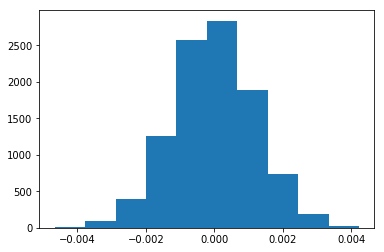

In [33]:
# A histogram of the p_diffs
plt.hist(p_diffs);

###### It is the null distribution, it is expected to be normal distributed and it is actually normal distributed here  

In [34]:
# calculate the observed(actual) difference
obs_diff = df2[df2['landing_page'] == "new_page"]['converted'].mean() - df2[df2['landing_page'] == "old_page"]['converted'].mean()
# The p-value (proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv)
(p_diffs > obs_diff).mean()

0.90610000000000002

###### This is the p-value, it is the observed significance level, the p-value here is large enough to suggest that we can not reject the null hypothesis which means that there is no differnece between the new and old pages 

### Using a built-in functions to test if results are similar.   

In [35]:
import statsmodels.api as sm
# The number of conversions for the old page
convert_old = df2[df2['landing_page'] == 'old_page']['converted'].sum()
# The number of conversions for the new page
convert_new = df2[df2['landing_page'] == 'new_page']['converted'].sum()
# The number of individuals who received the old page. 
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
# The number of individuals who received the new page. 
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
n_old, n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(145274, 145310)

In [36]:
# Compute test statistic and p-value
sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative="smaller")

(1.3109241984234394, 0.90505831275902449)

###### The results using built-in functions agree with the computed results before, this p-value means that we can not reject the null hypothesis which means that the old page has conversion rate equal or even better than the conversion rate of the new page 

<a id='regression'></a>
### Part III - A regression approach


###### Since there are only two possible outcomes - either a conversion or no conversion - then we can use logistic regression 

In [37]:
# Create a column for the intercept
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1


In [38]:
# Creating ab_page column, which is 1 when an individual receives the 'treatment' and 0 if 'control'.
df2['ab_page'] = pd.get_dummies(df['landing_page'])['new_page']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [39]:
# Instantiate a logistic regression model on the 'intercept' and 'ab_page' columns 
log_m = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
# Fit the model to predict whether or not an individual converts.
res = log_m.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [40]:
# A summary for the model 
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-10 12:18 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

###### The P-value is 0.1899, it differs from the p-value in Part II, this P value is for testing if the parameter for the slope is equal to zero in the null hypothesis, and the alternative hypothesis here is that the parameter is not equal to zero

###### Adding other factors to the regression model help it learn from more aspects that can affect the response and thus increse the accuracy of the model, when adding additional terms into the regression model one can face the problem of multicollinearity when our x-variables are correlated with one another where they should be correlated with the response but not to each other

## Add an effect based on which country a user lives in.  

In [41]:
# reading countries.csv
countries_df = pd.read_csv('countries.csv')
# checking number of rows for consistency
countries_df.shape, df2.shape

((290584, 2), (290584, 7))

In [42]:
# View few rows of the countries_df 
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
# Merging the two dataframes
df = pd.merge(left = df2, right = countries_df, on = 'user_id', how = 'outer')
# View few rows for checking 
df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [44]:
# Dummy varibles for the categorical "country" column
df = df.join(pd.get_dummies(df['country']))
# View few rows for checking 
df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [45]:
# A logistic regression model with 'intercept', 'ab_page', 'UK' and 'US' columns
log_m = sm.Logit(df['converted'], df[['intercept', 'ab_page', 'UK', 'US']])
# Fitting the model 
res = log_m.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [46]:
# View results of the model 
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-10 12:23 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

###### Countries especially UK seem to have impact on conversions, they even have lower P-values than ab_page

## Look at an interaction between page and country to see if there significant effects on conversion.  

In [47]:
# 'ab_page' and 'US' interaction
df['ab_page_US'] = df['ab_page'] * df['US']
# 'ab_page' and 'UK' interaction
df['ab_page_UK'] = df['ab_page'] * df['UK']
# View few rows for checking 
df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,ab_page_US,ab_page_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [48]:
# New logistic model with interactions 
log_m = sm.Logit(df['converted'], df[['intercept', 'ab_page', 'UK', 'US', 'ab_page_US', 'ab_page_UK']])
# Fitting the model 
res = log_m.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [49]:
# View summary
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-10 12:26 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_page_US     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
ab_page_UK     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

###### It seems that interactions have no significant effects on conversion, their P-values are large indicating that there is no significant effect, so there is no need for interactions 

## Experiment duration

In [50]:
# Convert 'timestamp' column to datetime to be able to calculate experiment duartion
date_edited = pd.to_datetime(df['timestamp'])
# Cheching 
date_edited.head()

0   2017-01-21 22:11:48.556739
1   2017-01-12 08:01:45.159739
2   2017-01-11 16:55:06.154213
3   2017-01-08 18:28:03.143765
4   2017-01-21 01:52:26.210827
Name: timestamp, dtype: datetime64[ns]

In [55]:
# Sort dates 
sorted_date = date_edited.sort_values(ascending=True)

In [58]:
# The duration of the experiment 
sorted_date[191059] - sorted_date[129421]  

Timedelta('21 days 23:59:49.081927')

## Conclusion 

#### -We failed to reject the null, the new page doesn't have better conversion rate than the old one
#### -Practically, these approximately equal conversion rates don't encourage to bear the cost of launching the new page
#### -The duration of three weeks and the balance in the population represented in each group seems enough to have sufficient data 
#### -An enhancement can be made to make sure that users can be attracted enough to the change